In [10]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from scipy.stats import norm, skewnorm

from proto.py.semihdp_pb2 import SemiHdpState

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"})

save = False

In [11]:
from google.protobuf.internal.decoder import _DecodeVarint32


def readManyFromFile(filename, msgType):
    out = []
    with open(filename, "rb") as fp:
        buf = fp.read()

    n = 0
    while n < len(buf):
        msg_len, new_pos = _DecodeVarint32(buf, n)
        n = new_pos
        msg_buf = buf[n:n+msg_len]
        try:
            msg = msgType()
            msg.ParseFromString(msg_buf)
            out.append(msg)
            n += msg_len
        except Exception as e:
            break

    return np.array(out)


def count_clusters(state):
    if len(state.restaurants) != 2:
        return
    
    if state.c[0] == state.c[1]:
        nshared = len(np.unique(state.restaurants[state.c[0]].table_to_shared)) -1
        nidio = len(np.unique(state.restaurants[state.c[0]].table_to_idio)) -1
        return nshared, [nidio, nidio]
    
    num_idio = [0, 0]
    for i, rest in enumerate(state.restaurants):
        num_idio[i] = len(state.restaurants[i].table_to_idio) - 1
        
    num_shared = len(np.unique(np.concatenate(
        [state.restaurants[0].table_to_shared, 
        state.restaurants[1].table_to_shared]))) - 1
    
    return num_shared, num_idio


def eval_dens(grid, chains, group):
    out = np.zeros((len(chains), len(grid)))
    for i, state in enumerate(chains):
        rest = state.restaurants[state.c[group]]
        curr = np.zeros((len(rest.theta_stars), len(grid)))
        weights = np.array(rest.n_by_clus)
        weights =  weights / np.sum(weights)
        for j, clusval in enumerate(rest.theta_stars):
            curr[j, :] = weights[j] * norm.pdf(
                grid, clusval.uni_ls_state.mean, np.sqrt(clusval.uni_ls_state.var))
        
        out[i, :] = np.sum(curr, axis=0)
    return out

In [44]:
# Scenario1

chainfiles = [
    "new_chains/s1e1_v2.recordio",
    "new_chains/s1e2_v2.recordio",
    "new_chains/s1e3_v2.recordio"
]

grids = [
    np.linspace(-5, 10, 500),
    np.linspace(-5, 20, 500),
    np.linspace(-5, 10, 500)
]

true_dens = [
    [0.5 * norm.pdf(grids[0], 0, 1) + 0.5 * norm.pdf(grids[0], 5, 1),
     0.5 * norm.pdf(grids[0], 0, 1) + 0.5 * norm.pdf(grids[0], 5, 1)],
    [0.5 * norm.pdf(grids[0], 0, 1) + 0.5 * norm.pdf(grids[0], 5, 1),
     0.5 * norm.pdf(grids[0], 0, 1) + 0.5 * norm.pdf(grids[0], 5, 1)],
    [0.8 * norm.pdf(grids[2], 0, 1) + 0.2 * norm.pdf(grids[2], 5, 1),
     0.2 * norm.pdf(grids[2], 0, 1) + 0.8 * norm.pdf(grids[2], 5, 1)]
]

In [58]:
scenario = 0
chains = readManyFromFile(chainfiles[scenario], SemiHdpState)[-1000:]
c_chain = np.vstack([x.c for x in chains if len(x.c)])
np.mean(c_chain[:, 0] == c_chain[:, 1])

0.976

In [59]:
len(chains)

1000

/home/mario/.local/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/mario/.local/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


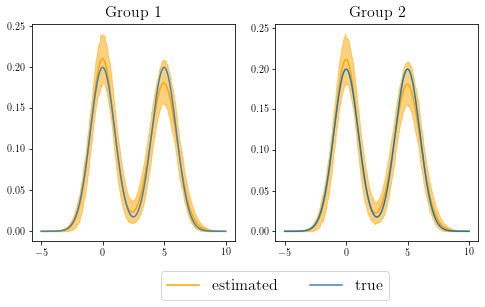

In [60]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

dens = eval_dens(grids[scenario], chains, 0)
axes[0].plot(grids[scenario], np.mean(dens, axis=0), color="orange", label="estimated")
hdis = az.hdi(dens)
axes[0].fill_between(grids[scenario], hdis[:, 0], hdis[:, 1], color="orange", alpha=0.5)
axes[0].plot(grids[scenario], true_dens[scenario][0], color="steelblue", label="true")
axes[0].set_title("Group 1", fontsize=16)

dens = eval_dens(grids[scenario], chains, 1)
axes[1].plot(grids[scenario], np.mean(dens, axis=0), color="orange")
hdis = az.hdi(dens)
axes[1].fill_between(grids[scenario], hdis[:, 0], hdis[:, 1], color="orange", alpha=0.5)
axes[1].plot(grids[scenario], true_dens[scenario][1])
axes[1].set_title("Group 2", fontsize=16)

axes[0].legend(fontsize=16, bbox_to_anchor=(1.8, -0.1), ncol=2)

if save:
    plt.savefig("s1e{0}_dens.pdf".format(scenario + 1), bbox_inches="tight")

plt.show()

In [ ]:
scenario = 1
chains = readManyFromFile(chainfiles[scenario], SemiHdpState)
chains = [state for state in chains if len(state.c)]
cluscount = [count_clusters(x) for x in chains if len(x.c)]

In [ ]:
chainsk1 = readManyFromFile("new_chains/s1e3_k1.recordio", SemiHdpState)
cluscountk1 = [count_clusters(x) for x in chainsk1[:100] if len(x.c)]

In [ ]:
shared = np.array([x[0] for x in cluscount])
idio0 = np.array([x[1][0] for x in cluscount])
idio1 = np.array([x[1][1] for x in cluscount])

sharedk1 = np.array([x[0] for x in cluscountk1])
idio0k1 = np.array([x[1][0] for x in cluscountk1])
idio1k1 = np.array([x[1][1] for x in cluscountk1])

xx = np.arange(0, 7)
heights = np.array([np.sum(shared == x) for x in xx])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 2))

heights = np.array([np.sum(shared == x) for x in xx])
axes[0].plot(xx, heights / np.sum(heights), "-x", lw=2, label=r"$\kappa \sim Beta(2, 2)$")
heights = np.array([np.sum(sharedk1 == x) for x in xx])
axes[0].plot(xx, heights / np.sum(heights), "-x", lw=2, label=r"$\kappa = 1$")
axes[0].set_title("Shared", fontsize=14)

heights = np.array([np.sum(idio0 == x) for x in xx])
axes[1].plot(xx, heights / np.sum(heights), "-x", lw=2)
heights = np.array([np.sum(idio0k1 == x) for x in xx])
axes[1].plot(xx, heights / np.sum(heights), "-x", lw=2)
axes[1].set_title("Group 1", fontsize=14)

heights = np.array([np.sum(idio1 == x) for x in xx])
axes[2].plot(xx, heights / np.sum(heights), "-x", lw=2)
heights = np.array([np.sum(idio1k1 + 1 == x) for x in xx])
axes[2].plot(xx, heights / np.sum(heights), "-x", lw=2)
axes[2].set_title("Group 2", fontsize=14)

for i in range(3):
    axes[i].set_xticks(xx)
    axes[i].set_ylim(0, 1.1)
    

axes[0].legend(ncol=2, bbox_to_anchor=(2.5, -0.1), fontsize=14)

plt.savefig("clusters_s1e2.pdf", bbox_inches="tight")

plt.show()

# Simulation 2

In [3]:
import json
import numpy as np
import pandas as pd
from collections import defaultdict


def indicatorChainToClusters(rhoChain):
    elems = set(rhoChain.flatten().tolist())
    out = []
    for i in range(rhoChain.shape[0]):
        row = rhoChain[i, ]
        clusters = []
        for e in elems.intersection(row):
            clus = np.where(row == e)[0] + 1
            clusters.append(tuple(clus.tolist()))

        out.append(sorted(tuple(clusters)))
    return out


def indicatorToCluster(rho):
    out = defaultdict(list)
    for pos, ind in enumerate(rho):
        out[ind].append(pos + 1)

    return json.dumps(sorted(list(out.values())))


def countClusters(rho):
    clusters = indicatorChainToClusters(rho)
    out = defaultdict(int)
    for clus in clusters:
        out[json.dumps(list(clus))] += 1

    return out

In [61]:
# compute ESS

chains = readManyFromFile("new_chains/s2e1_fullv2.recordio", SemiHdpState)[:1000]
nclus_chain = np.array([len(np.unique(x.c)) for x in chains])
az.ess(nclus_chain) / 33 # 57

7.793645074800626

([<matplotlib.axis.XTick at 0x7fb08dfdadc0>,
 [Text(0, 0, '[[1, 2, 3], [4]]'),
  Text(0, 0, '[[1, 4], [2, 3]]'),
  Text(0, 0, '[[1], [2, 3], [4]]'),
  Text(0, 0, '[[1, 4], [2], [3]]'),
  Text(0, 0, '[[1, 2], [3], [4]]')])

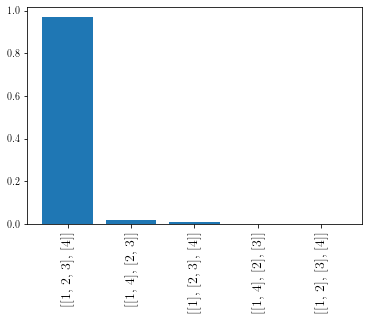

In [62]:
c_chain = np.vstack([x.c for x in chains])
clus = countClusters(c_chain)
heights = np.array(list(clus.values()))
heights = heights / np.sum(heights)
keep = np.argsort(heights)[::-1][:5]
labels = [list(clus.keys())[k] for k in keep]
plt.bar(np.arange(len(labels)), heights[keep])
plt.xticks(np.arange(len(labels)), labels, fontsize=14, rotation=90)
# plt.savefig("s2e1_clus.pdf", bbox_inches="tight")

In [ ]:
grid = np.linspace(-5, 5, 1000)
true_dens = [norm.pdf(grid), norm.pdf(grid), norm.pdf(grid), skewnorm.pdf(grid, 1)]

chains = np.array(chains)[np.arange(0, len(chains), 10)]

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 2.5))
for i in range(4):
    dens = eval_dens(grid, chains, i)
    axes[i].plot(grid, np.mean(dens, axis=0), color="orange", label="estimated")
    hdis = az.hdi(dens)
    axes[i].fill_between(grid, hdis[:, 0], hdis[:, 1], color="orange", alpha=0.5)
    axes[i].plot(grid, true_dens[i], color="steelblue", label="true")
    axes[i].set_title("Group {0}".format(i+1), fontsize=16)

axes[2].legend(ncol=2, fontsize=14, bbox_to_anchor=(0.8, -0.1))
plt.savefig("s2e1_dens.pdf", bbox_inches="tight")
plt.show()

In [ ]:
chains = readManyFromFile("/home/mario/dev/bayesmix/s2e1_metro_base.recordio", SemiHdpState)
nclus_chain = np.array([len(np.unique(x.c)) for x in chains])
az.ess(nclus_chain) / 30 # 22.035303533564388

In [ ]:
chains = readManyFromFile("/home/mario/dev/bayesmix/s2e1_metro_dist.recordio", SemiHdpState)
nclus_chain = np.array([len(np.unique(x.c)) for x in chains])
az.ess(nclus_chain) / 33 # 28.121302472556675

In [ ]:
chains = readManyFromFile("/home/mario/dev/bayesmix/s2e2.recordio", SemiHdpState)
c_chain = np.vstack([x.c for x in chains])
clus = countClusters(c_chain)
clus
# best clust 85%

In [ ]:
chains = readManyFromFile("/home/mario/dev/bayesmix/s2e3.recordio", SemiHdpState)
c_chain = np.vstack([x.c for x in chains])
clus = countClusters(c_chain)
clus
# best clust 99.58%

# Simulation 100 Populations

In [ ]:
chains = readManyFromFile("/home/mario/dev/bayesmix/build/s100.recordio", SemiHdpState)

In [ ]:
c_chain = np.vstack([x.c for x in chains])
psm = np.zeros((c_chain.shape[1], c_chain.shape[1]))
for i in range(100):
    for j in range(i + 1):
        psm[i, j] = np.mean(c_chain[:, i] == np.mean(c_chain[:, j]))
        psm[j, i] = psm[i, j]
        
plt.imshow(psm, cmap=rdbu, vmin=-1.0, vmax=1.0)

In [ ]:
def m(a, b): return b / (a - 1)
def v(a, b): return b**2 / ((a-1) * (a-2))

In [ ]:
a = 50
b = 10

print(m(a, b), v(a, b))

# Chile

In [ ]:
y_obs_df = pd.read_csv("/home/mario/PhD/exchangeability/data/grades_chile_norm.csv")
y_obs1 = y_obs_df[y_obs_df["Sec."] == 1]["FinalGrade"].values
y_obs2 = y_obs_df[y_obs_df["Sec."] == 2]["FinalGrade"].values
y_obs3 = y_obs_df[y_obs_df["Sec."] == 3]["FinalGrade"].values

densities = [None, None, None]

In [ ]:
chains = readManyFromFile("new_chains/chile.recordio", SemiHdpState)

In [ ]:
grid = np.linspace(-5, 5, 200)
true_dens = [norm.pdf(grid), norm.pdf(grid), norm.pdf(grid), skewnorm.pdf(grid, 1)]

# chains = np.array(chains)[np.arange(0, len(chains), 10)]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(5, 2.5))
for i in range(3):
    dens = eval_dens(grid, chains, i)
    densities[i] = dens
    y_obs = y_obs_df[y_obs_df["Sec."] == i+1]["FinalGrade"].values
    axes[i].hist(y_obs, density=True, fill=False, bins=5)
    axes[i].plot(grid, np.mean(dens, axis=0), color="orange", label="estimated")
    hdis = az.hdi(dens)
    axes[i].fill_between(grid, hdis[:, 0], hdis[:, 1], color="orange", alpha=0.5)

axes[0].set_title("Section A", fontsize=14)
axes[1].set_title("Section B", fontsize=14)
axes[2].set_title("Section C", fontsize=14)


plt.tight_layout()
# plt.savefig("chile_dens.pdf")
plt.show()

In [ ]:
c_chain = np.vstack([x.c for x in chains])
clus = countClusters(c_chain)
heights = np.array(list(clus.values()))
heights = heights / np.sum(heights)
keep = np.argsort(heights)[::-1][:5]
labels = [list(clus.keys())[k] for k in keep]

plt.figure(figsize=(1.5, 2.75), tight_layout=True)

plt.bar(np.arange(len(labels)), heights[keep], width=0.3)
plt.xticks(np.arange(len(labels)), labels, fontsize=14, rotation=90)
plt.title(r"$P(\rho | data)$")
plt.savefig("chile_clusters.pdf")
plt.show()

In [ ]:
len(densities)

In [ ]:
# Expected values
x = grid

mean_densities = [np.mean(d, 0) for d in densities]
means = [np.sum(x * d) * (x[1] - x[0]) for d in mean_densities]
means

In [ ]:
# variances
variances = [np.sum( x**2 * d) * (x[1] - x[0]) - m**2 for d, m in zip(mean_densities, means)]
variances

In [ ]:
# pairwise Lp distances
pp = [1, 2]

dists = []
for p in pp:
    curr = {}
    for i in range(3):
        f = mean_densities[i]
        for j in range(i):
            g = mean_densities[j]
            curr[(i+1, j+1)] = np.sum(np.abs(f-g) ** p) * (x[1] - x[0])
            
    dists.append(curr)
    
print(dists[0])
print(dists[1])

In [ ]:
def skewness(dens, xgrid):
    mean = np.sum(xgrid * dens) * (xgrid[1] - xgrid[0])
    var = np.sum(xgrid**2 * dens) * (xgrid[1] - xgrid[0]) - mean**2
    stddev = np.sqrt(var)
    return np.sum( ((xgrid - mean) / stddev)**3) * (xgrid[1] - xgrid[0]) 

def kurtosis(dens, xgrid):
    mean = np.sum(xgrid * dens) * (xgrid[1] - xgrid[0])
    var = np.sum(xgrid**2 * dens) * (xgrid[1] - xgrid[0]) - mean**2
    stddev = np.sqrt(var)
    return np.sum( ((xgrid - mean) / stddev)**4) * (xgrid[1] - xgrid[0]) 
    
print([skewness(d, x) for d in mean_densities])
print([kurtosis(d, x) for d in mean_densities])

In [ ]:
# measure of skewness wrt the mode
def arnold_gro(dens, xgrid):
    mode_ind = np.argmax(dens)
    x = xgrid[np.arange(mode_ind)]
    cdf = np.cumsum(dens) * (xgrid[1] - xgrid[0])
    return 1 - 2 * cdf[mode_ind]

print([arnold_gro(d, x) for d in mean_densities])

In [ ]:
# probability of passing

mu = 4.2125
sigma = 1.25

passing_thr = (4 - mu) / sigma

wh = np.where(x >= passing_thr-0.15)[0]

passing_probs = [np.sum(d[wh]) * (x[1]-x[0]) for d in mean_densities]
print(passing_probs)

## Joint Density Plots

In [ ]:
joint12 = np.zeros((len(x), len(x)))
for i in range(densities[0].shape[0]):
    joint12 += np.outer(densities[0][i, :], densities[1][i, :])
    
joint13 = np.zeros((len(x), len(x)))
for i in range(densities[0].shape[0]):
    joint13 += np.outer(densities[0][i, :], densities[2][i, :])
    
    
joint23 = np.zeros((len(x), len(x)))
for i in range(densities[1].shape[0]):
    joint23 += np.outer(densities[1][i, :], densities[2][i, :])
    
joint12 /= densities[1].shape[0]
joint13 /= densities[1].shape[0]
joint23 /= densities[1].shape[0]

In [ ]:
mind = 0
maxd = np.max([joint12, joint13, joint23])

levels = np.linspace(0, maxd, 10)

fig, axes = plt.subplots(1, 3, figsize=(13, 5))
axes[0].contourf(x, x, joint12, vmin=0, vmax=maxd, levels=levels)
axes[0].set_title("Sections A and B", fontsize=18)
axes[1].contourf(x, x, joint13, vmin=0, vmax=maxd, levels=levels)
axes[1].set_title("Sections A and C", fontsize=18)
cs = axes[2].contourf(x, x, joint23, vmin=0, vmax=maxd, levels=levels)
axes[2].set_title("Section B and C", fontsize=18)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(cs, cax=cbar_ax)
cbar_ax.tick_params(labelsize=14) 

for i in range(3):
    axes[i].set_ylim(-2.5, 3)
    axes[i].set_xlim(-2.5, 3)

plt.savefig("chile_joint.pdf")
plt.show()

In [ ]:
maxd